# Here we evaluate the different sampling methods with a learning rate or 0.1 and 128 dense layers.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import joblib
import torch
from Models.models import NNdynamic, plot_confusion_matrix, plot_metrics

In [2]:
data = pd.read_csv('Cleaned_full_data.csv')

C:\Users\adi_s\AppData\Local\Temp\ipykernel_1044\2584280520.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Cleaned_full_data.csv')


In [3]:
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')

In [4]:
data = data.drop(columns=['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])

In [5]:
temp = data[['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat']]
data = data.drop(columns=['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat'])

In [6]:
# The resulting encoded features can be found in Tools/EncoderTests.
ohe1 = pd.read_csv('Full_proto_encoded.csv')
ohe2 = pd.read_csv('Full_dsport_encoded.csv')
ohe3 = pd.read_csv('Full_service_encoded.csv')
ohe4 = pd.read_csv('Full_state_encoded.csv')
# Spelling error.
ohe5 = pd.read_csv('Full_scrip_encoded.csv')
#------------------------------------------#
ohe6 = pd.read_csv('Full_sport_encoded.csv')
ohe7 = pd.read_csv('Full_dstip_encoded.csv')

In [7]:
# MinMax seperates Normal data well and reduces noise. Please see Kmeans TSNE evaluation in Tools.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, columns=data.columns)
data = pd.concat([data, temp, ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)

In [8]:
X_temp = data.drop(columns=['label'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y, test_size=0.2, random_state=42)
test_attack_cat = X_test['attack_cat']
print('Train:', y_train.value_counts())
print('Test', y_test.value_counts())
X_train = X_train.drop(columns=['attack_cat'])
X_test = X_test.drop(columns=['attack_cat'])

Train: label
0    1774933
1     257104
Name: count, dtype: int64
Test label
0    443831
1     64179
Name: count, dtype: int64


In [9]:
# Prepare batches.
batch_size = 128
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/01/smote/'
model1 = NNdynamic(n_features, fc_size, device, save_dir)

In [ ]:
# 37.23 min
sampler = 'smote'
params = {'k_neighbors': 2}
learning_rate = 0.1
epochs = 5
save_factor = 1
model1.run(train_loader, learning_rate, epochs, save_factor, sampler, params)
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
print('SMOTE Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

In [20]:
model1.load_model('./Models/saved_models/01/smote/PB_epoch_5.pth')

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 1


Testing: 100%|██████████| 3969/3969 [00:10<00:00, 378.86batch/s]


Test Loss: 0.0258, Test Accuracy: 0.9875, Test F1: 0.9879


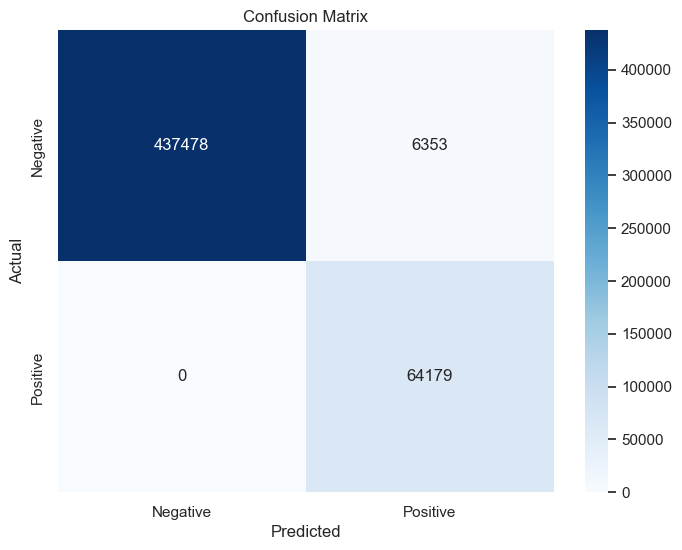

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 2


Testing: 100%|██████████| 3969/3969 [00:10<00:00, 387.83batch/s]


Test Loss: 0.0306, Test Accuracy: 0.9878, Test F1: 0.9882


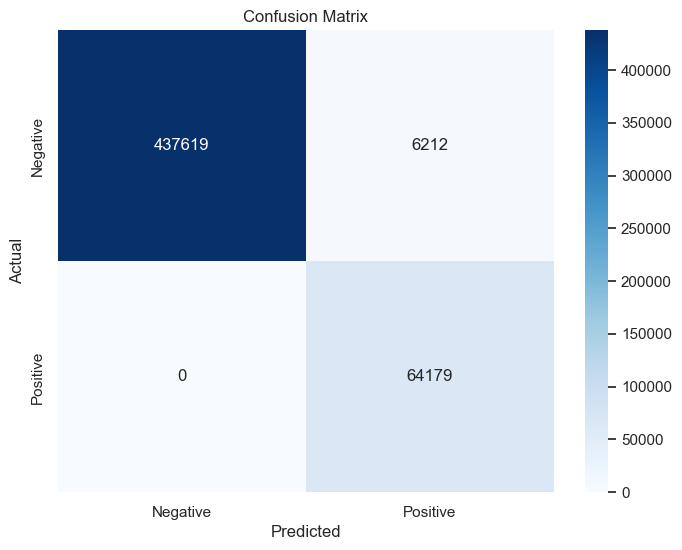

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 3


Testing: 100%|██████████| 3969/3969 [00:10<00:00, 384.14batch/s]


Test Loss: 0.0198, Test Accuracy: 0.9925, Test F1: 0.9925


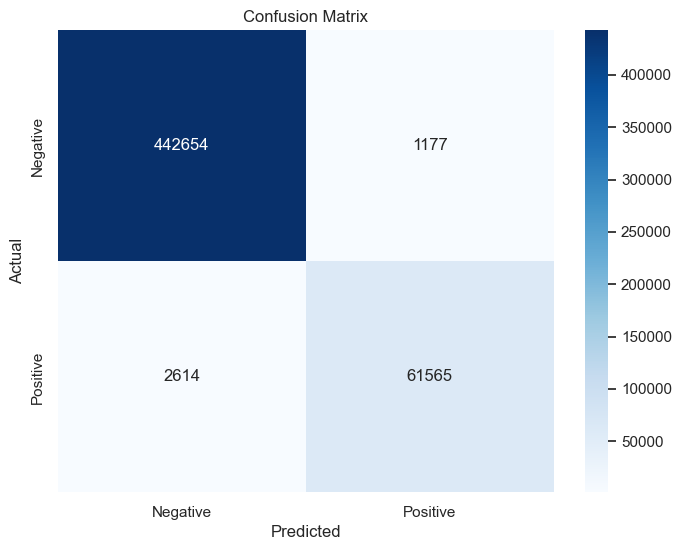

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 4


Testing: 100%|██████████| 3969/3969 [00:10<00:00, 389.66batch/s]


Test Loss: 0.0215, Test Accuracy: 0.9878, Test F1: 0.9882


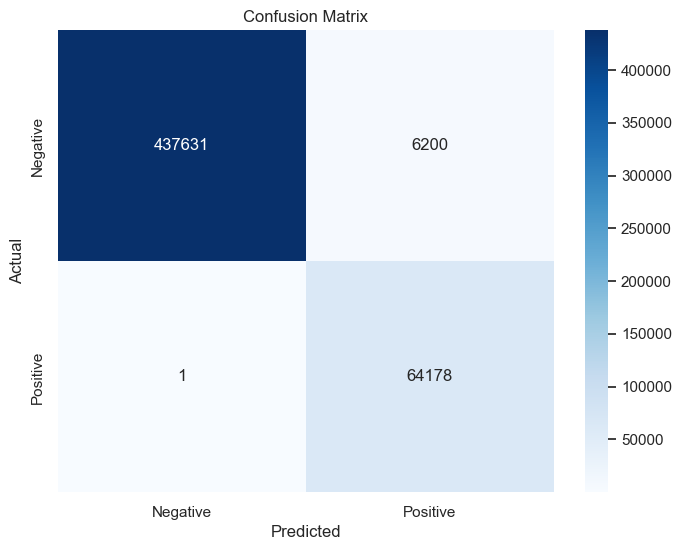

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 5


Testing: 100%|██████████| 3969/3969 [00:10<00:00, 386.65batch/s]


Test Loss: 0.0182, Test Accuracy: 0.9878, Test F1: 0.9882


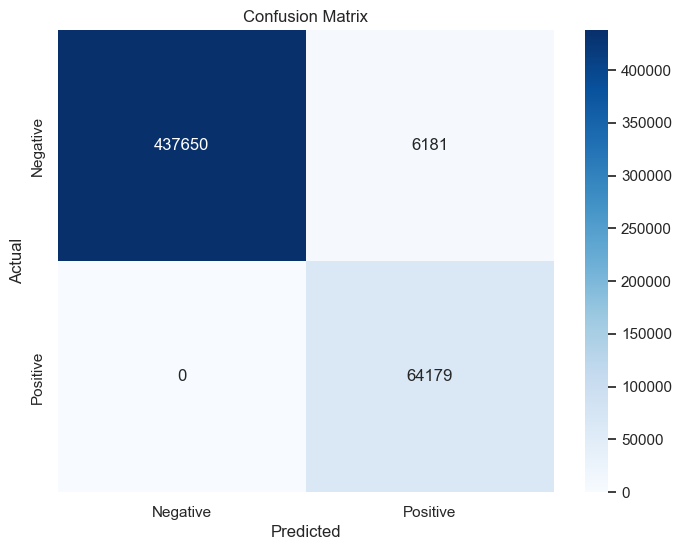

In [21]:
for i in range(1, epochs+1):
    path = f"./Models/saved_models/01/smote/PB_epoch_{i}.pth"
    model1.load_model(path)
    print(f"Epoch: {i}")
    model1.test(test_loader)
    y_pred = np.array(model1.test_predicted)
    y_true = []
    for _, labels in test_loader:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    plot_confusion_matrix(y_true, y_pred)
    model1.test_predicted = []

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/01/tomeks/'
model2 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/5: 100%|██████████| 15876/15876 [05:35<00:00, 47.26batch/s]


Epoch [1/5], Train Loss: 0.0149, Train Acc: 0.9905, Train F1: 0.9903


Epoch 2/5: 100%|██████████| 15876/15876 [06:36<00:00, 40.01batch/s]


Epoch [2/5], Train Loss: 0.0149, Train Acc: 0.9901, Train F1: 0.9899


Epoch 3/5: 100%|██████████| 15876/15876 [06:33<00:00, 40.32batch/s]


Epoch [3/5], Train Loss: 0.0144, Train Acc: 0.9909, Train F1: 0.9907


Epoch 4/5: 100%|██████████| 15876/15876 [06:29<00:00, 40.80batch/s]


Epoch [4/5], Train Loss: 0.0149, Train Acc: 0.9904, Train F1: 0.9902


Epoch 5/5: 100%|██████████| 15876/15876 [06:29<00:00, 40.80batch/s]


Epoch [5/5], Train Loss: 0.0145, Train Acc: 0.9904, Train F1: 0.9901


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 342.15batch/s]

Test Loss: 0.0168, Test Accuracy: 0.9909, Test F1: 0.9906


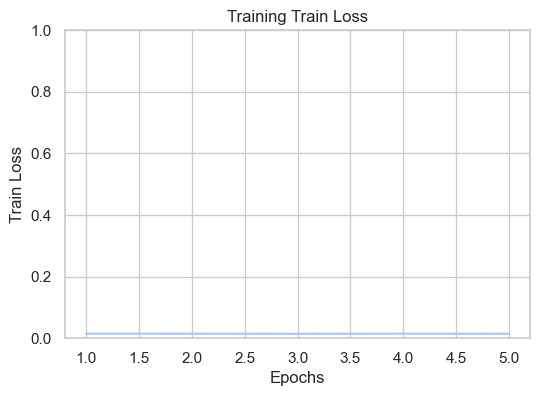

Tomeks Test


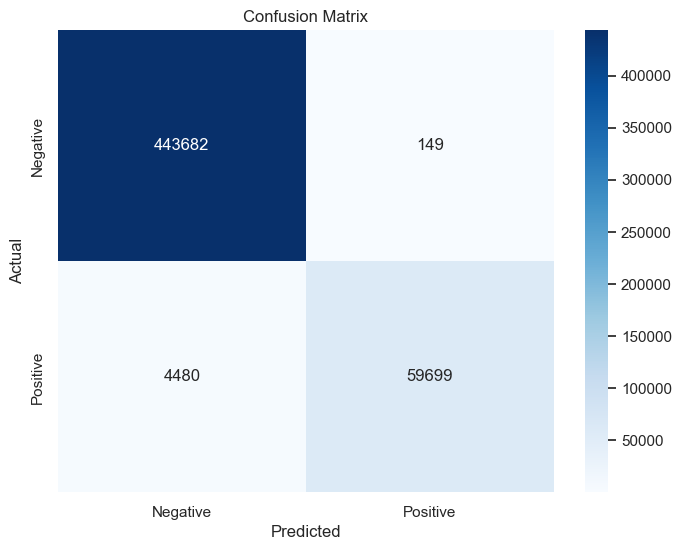

In [ ]:
# 31.57 min
sampler = 'tomeks'
params = {'sampling_strategy': 'auto'}
learning_rate = 0.1
epochs = 5
save_factor = 1
model2.run(train_loader, learning_rate, epochs, save_factor, sampler, params)
model2.test(test_loader)
plot_metrics(model2.train_loss, len(model2.train_loss), title="Train Loss")
print('Tomeks Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model2.test_predicted)

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 1


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 347.04batch/s]


Test Loss: 0.0184, Test Accuracy: 0.9877, Test F1: 0.9881


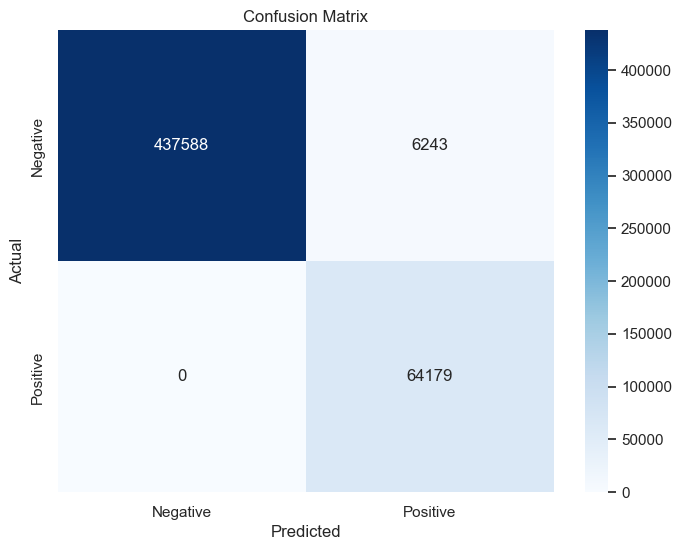

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 2


Testing: 100%|██████████| 3969/3969 [00:12<00:00, 326.22batch/s]


Test Loss: 0.0214, Test Accuracy: 0.9878, Test F1: 0.9882


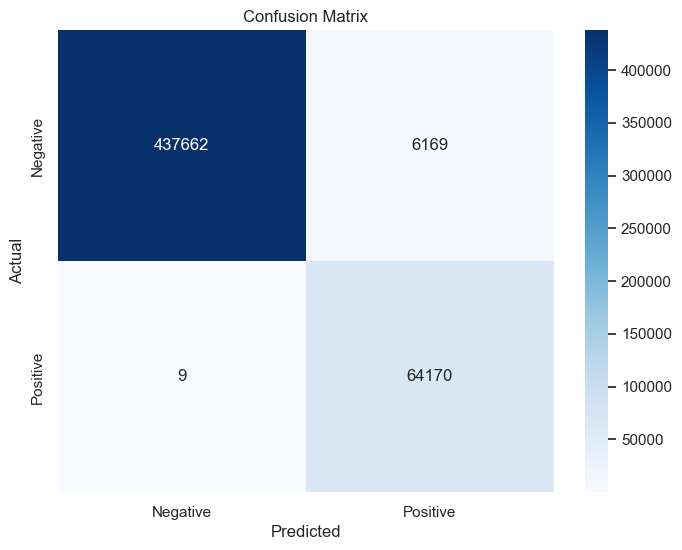

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 3


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 348.80batch/s]


Test Loss: 0.0175, Test Accuracy: 0.9895, Test F1: 0.9892


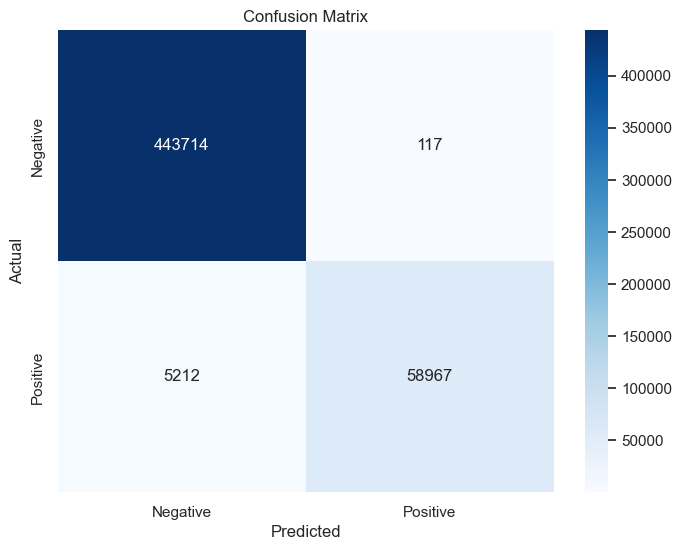

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 4


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 347.50batch/s]


Test Loss: 0.0175, Test Accuracy: 0.9902, Test F1: 0.9899


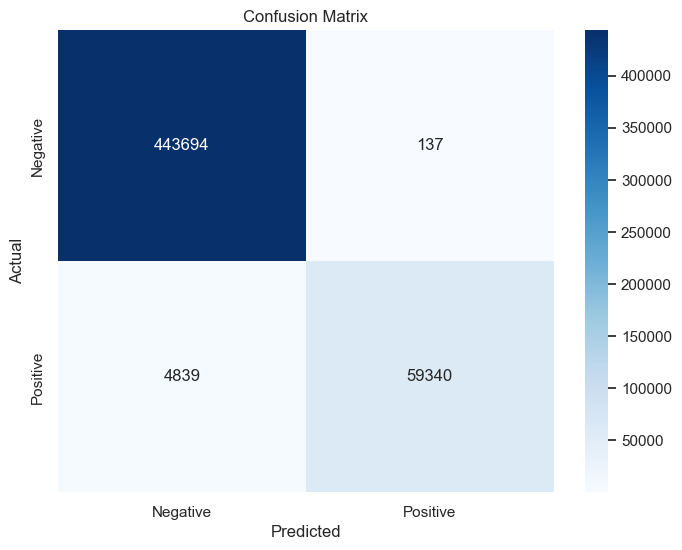

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 5


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 343.24batch/s]


Test Loss: 0.0168, Test Accuracy: 0.9909, Test F1: 0.9906


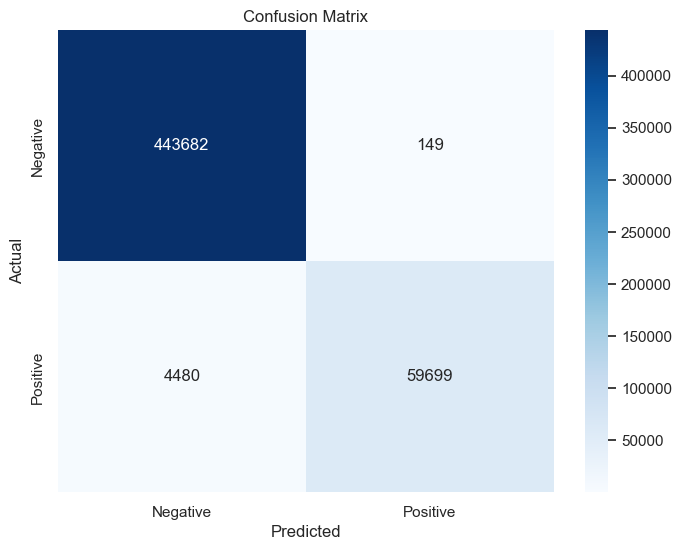

In [25]:
for i in range(1, epochs+1):
    path = f"./Models/saved_models/01/tomeks/PB_epoch_{i}.pth"
    model2.load_model(path)
    print(f"Epoch: {i}")
    model2.test(test_loader)
    y_pred = np.array(model2.test_predicted)
    y_true = []
    for _, labels in test_loader:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    plot_confusion_matrix(y_true, y_pred)
    model2.test_predicted = []

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/01/edited_nearest/'
model3 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/5: 100%|██████████| 15876/15876 [06:56<00:00, 38.09batch/s]


Epoch [1/5], Train Loss: 0.0109, Train Acc: 0.9948, Train F1: 0.9948


Epoch 2/5: 100%|██████████| 15876/15876 [06:57<00:00, 38.04batch/s]


Epoch [2/5], Train Loss: 0.0100, Train Acc: 0.9952, Train F1: 0.9952


Epoch 3/5: 100%|██████████| 15876/15876 [06:45<00:00, 39.18batch/s]


Epoch [3/5], Train Loss: 0.0105, Train Acc: 0.9953, Train F1: 0.9953


Epoch 4/5: 100%|██████████| 15876/15876 [06:48<00:00, 38.82batch/s]


Epoch [4/5], Train Loss: 0.0101, Train Acc: 0.9952, Train F1: 0.9952


Epoch 5/5: 100%|██████████| 15876/15876 [06:42<00:00, 39.40batch/s]


Epoch [5/5], Train Loss: 0.0104, Train Acc: 0.9955, Train F1: 0.9956


Testing: 100%|██████████| 3969/3969 [00:10<00:00, 364.84batch/s]

Test Loss: 0.0191, Test Accuracy: 0.9901, Test F1: 0.9898


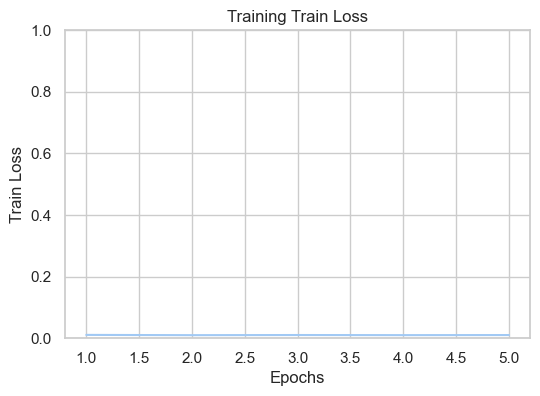

Testing: 100%|██████████| 3969/3969 [00:10<00:00, 383.35batch/s]


Test Loss: 0.0191, Test Accuracy: 0.9901, Test F1: 0.9898
Edited Nearest Test


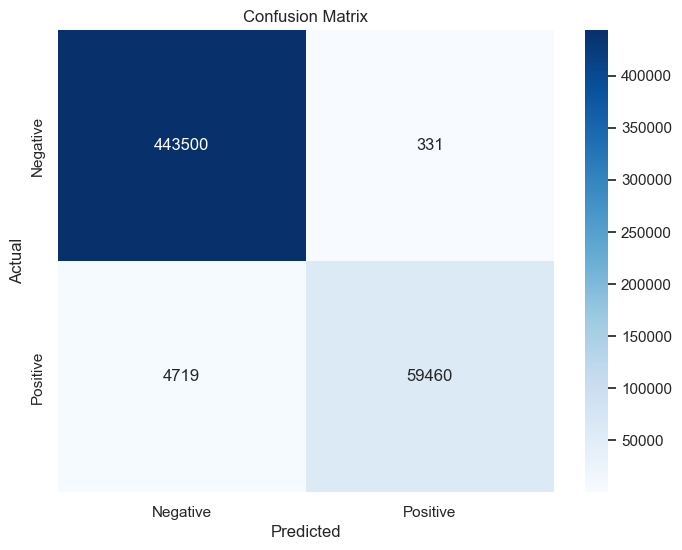

In [ ]:
# 34.33 min
sampler = 'edited_nearest'
params = {'n_neighbors': 2}
learning_rate = 0.1
epochs = 5
save_factor = 1
model3.run(train_loader, learning_rate, epochs, save_factor, sampler, params)
model3.test(test_loader)
plot_metrics(model3.train_loss, len(model3.train_loss), title="Train Loss")
model3.test(test_loader)
print('Edited Nearest Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model3.test_predicted)

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 1


Testing: 100%|██████████| 3969/3969 [00:10<00:00, 384.87batch/s]


Test Loss: 0.0178, Test Accuracy: 0.9911, Test F1: 0.9909


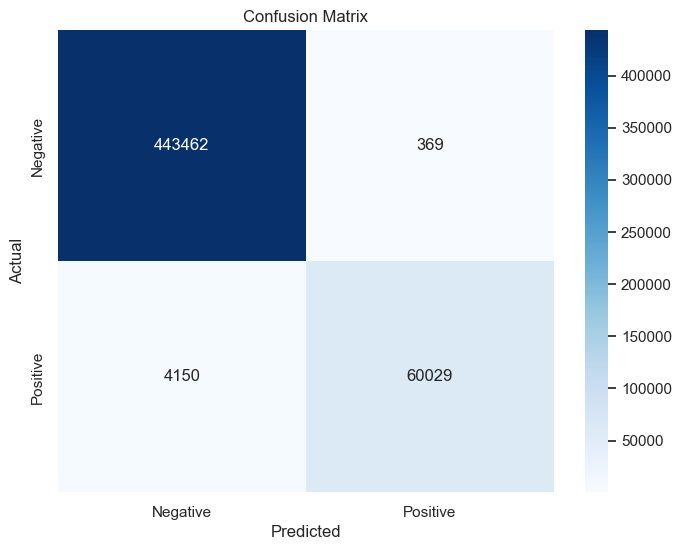

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 2


Testing: 100%|██████████| 3969/3969 [00:10<00:00, 375.46batch/s]


Test Loss: 0.0191, Test Accuracy: 0.9911, Test F1: 0.9909


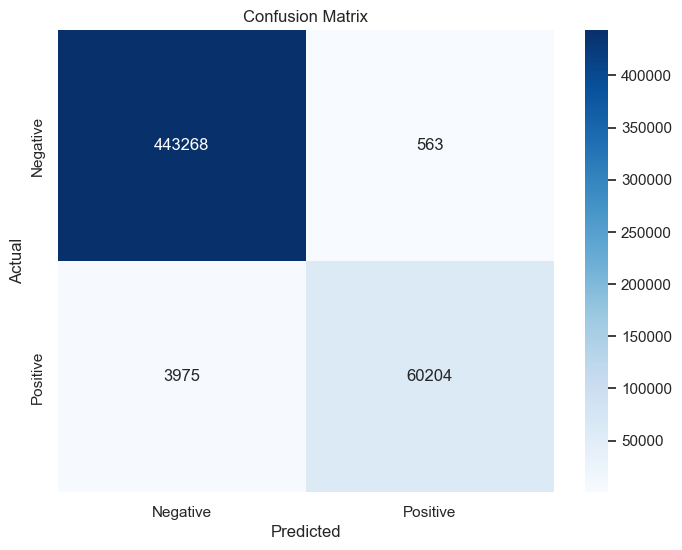

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 3


Testing: 100%|██████████| 3969/3969 [00:10<00:00, 379.94batch/s]


Test Loss: 0.0210, Test Accuracy: 0.9862, Test F1: 0.9867


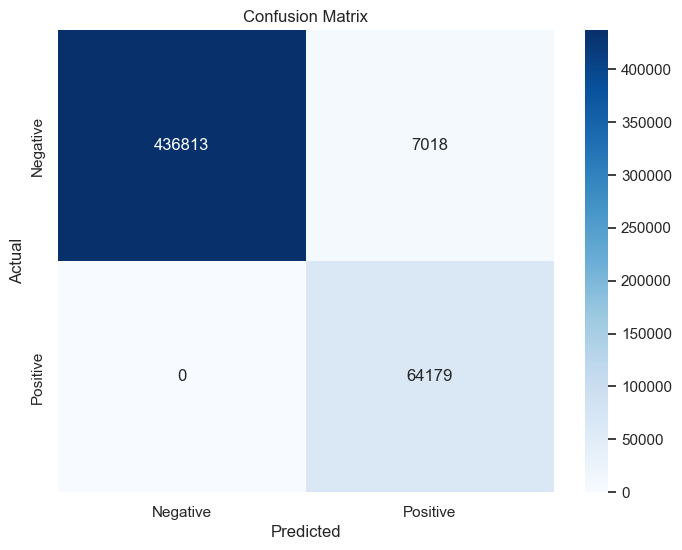

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 4


Testing: 100%|██████████| 3969/3969 [00:10<00:00, 381.24batch/s]


Test Loss: 0.0201, Test Accuracy: 0.9878, Test F1: 0.9882


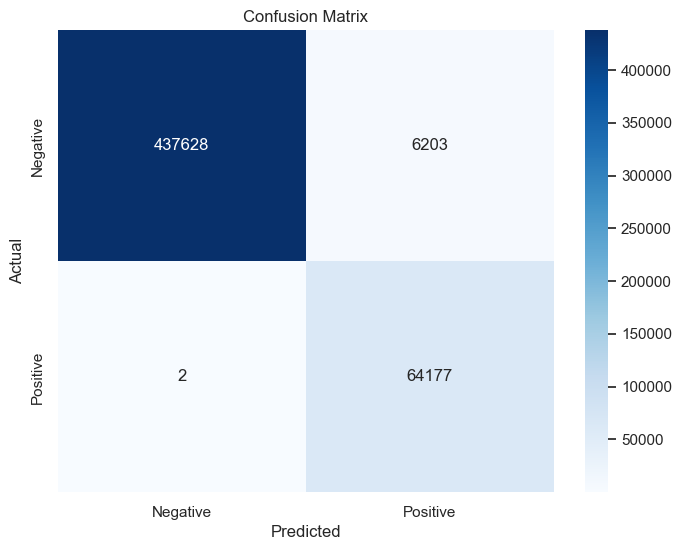

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 5


Testing: 100%|██████████| 3969/3969 [00:10<00:00, 387.87batch/s]


Test Loss: 0.0191, Test Accuracy: 0.9901, Test F1: 0.9898


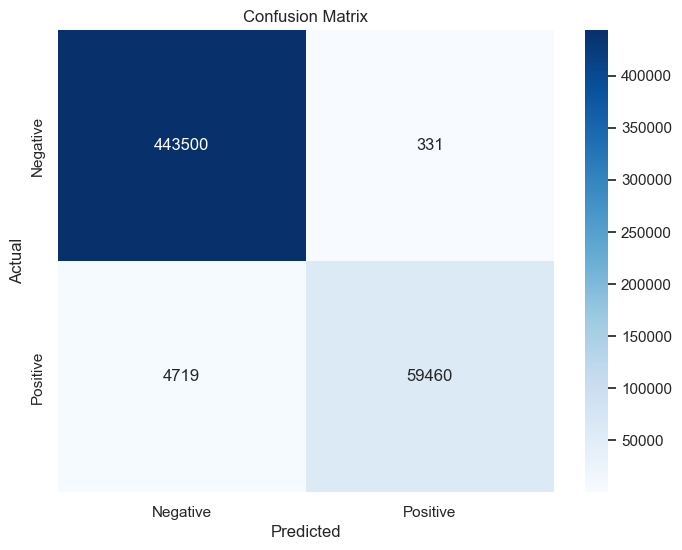

In [28]:
for i in range(1, epochs+1):
    path = f"./Models/saved_models/01/edited_nearest/PB_epoch_{i}.pth"
    model3.load_model(path)
    print(f"Epoch: {i}")
    model3.test(test_loader)
    y_pred = np.array(model3.test_predicted)
    y_true = []
    for _, labels in test_loader:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    plot_confusion_matrix(y_true, y_pred)
    model3.test_predicted = []

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/01/near_miss/'
model4 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/5: 100%|██████████| 15876/15876 [05:35<00:00, 47.35batch/s]


Epoch [1/5], Train Loss: 0.0494, Train Acc: 0.9703, Train F1: 0.9702


Epoch 2/5: 100%|██████████| 15876/15876 [05:43<00:00, 46.21batch/s]


Epoch [2/5], Train Loss: 0.0466, Train Acc: 0.9707, Train F1: 0.9706


Epoch 3/5: 100%|██████████| 15876/15876 [05:36<00:00, 47.17batch/s]


Epoch [3/5], Train Loss: 0.0492, Train Acc: 0.9709, Train F1: 0.9707


Epoch 4/5: 100%|██████████| 15876/15876 [05:45<00:00, 45.93batch/s]


Epoch [4/5], Train Loss: 0.0474, Train Acc: 0.9698, Train F1: 0.9696


Epoch 5/5: 100%|██████████| 15876/15876 [05:47<00:00, 45.64batch/s]


Epoch [5/5], Train Loss: 0.0495, Train Acc: 0.9698, Train F1: 0.9697


Testing: 100%|██████████| 3969/3969 [00:12<00:00, 316.54batch/s]


Test Loss: 0.0224, Test Accuracy: 0.9915, Test F1: 0.9913


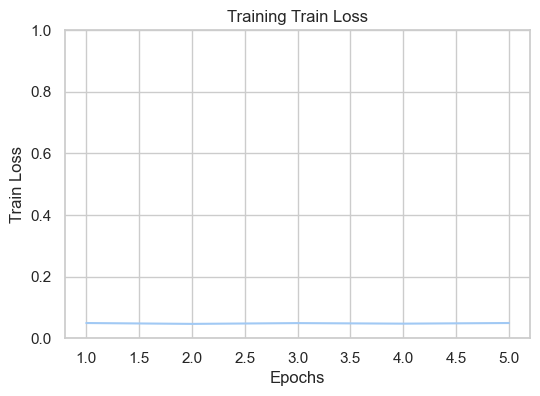

Testing: 100%|██████████| 3969/3969 [00:12<00:00, 321.45batch/s]


Test Loss: 0.0224, Test Accuracy: 0.9915, Test F1: 0.9913
Near Miss Test


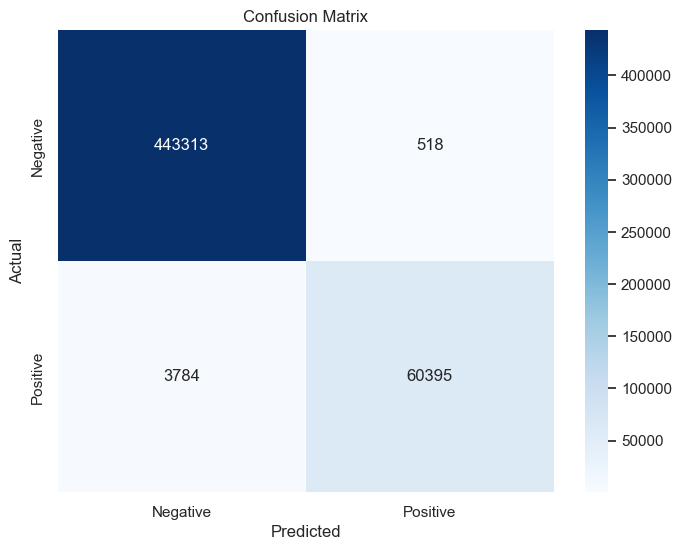

In [ ]:
# 28.54 min
sampler = 'near_miss'
params = {'n_neighbors': 2}
learning_rate = 0.1
epochs = 5
save_factor = 1
model4.run(train_loader, learning_rate, epochs, save_factor, sampler, params)
model4.test(test_loader)
plot_metrics(model4.train_loss, len(model4.train_loss), title="Train Loss")
model4.test(test_loader)
print('Near Miss Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model4.test_predicted)

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 1


Testing: 100%|██████████| 3969/3969 [00:12<00:00, 329.70batch/s]


Test Loss: 0.0229, Test Accuracy: 0.9918, Test F1: 0.9917


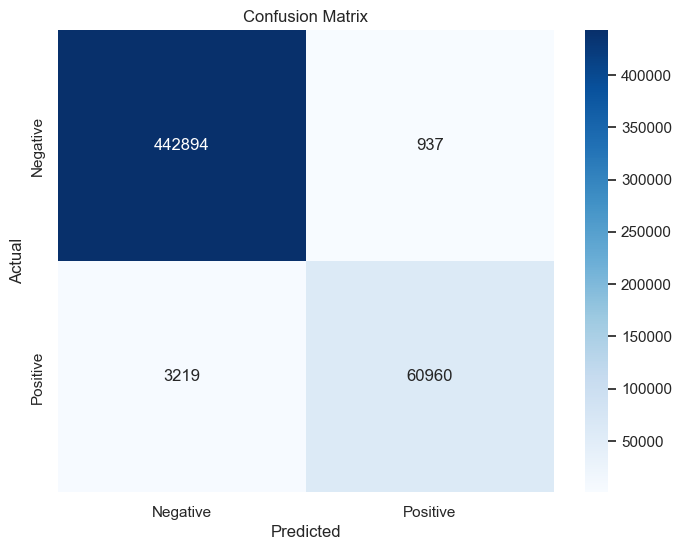

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 2


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 330.83batch/s]


Test Loss: 0.0244, Test Accuracy: 0.9920, Test F1: 0.9919


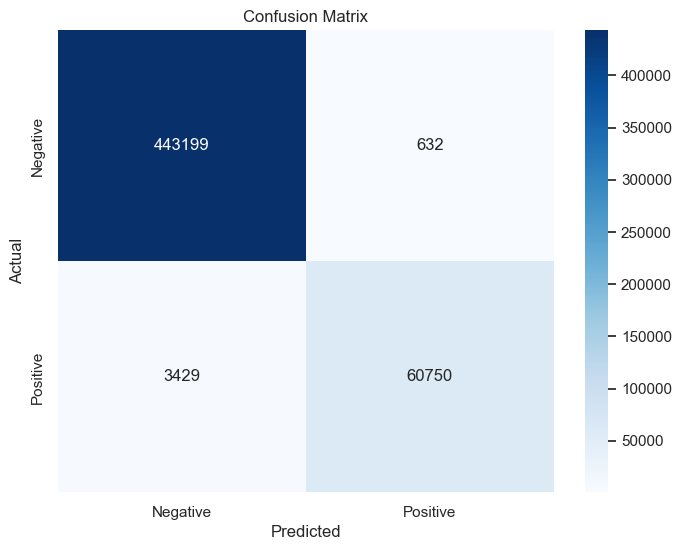

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 3


Testing: 100%|██████████| 3969/3969 [00:12<00:00, 330.09batch/s]


Test Loss: 0.0279, Test Accuracy: 0.9841, Test F1: 0.9847


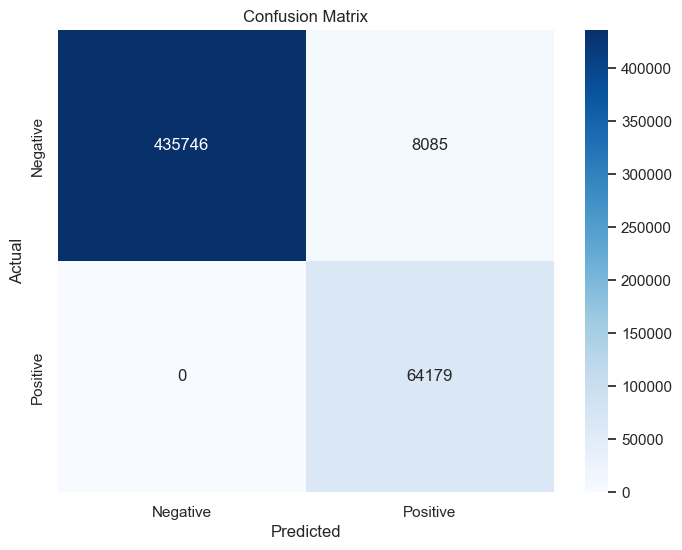

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 4


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 335.25batch/s]


Test Loss: 0.0212, Test Accuracy: 0.9911, Test F1: 0.9910


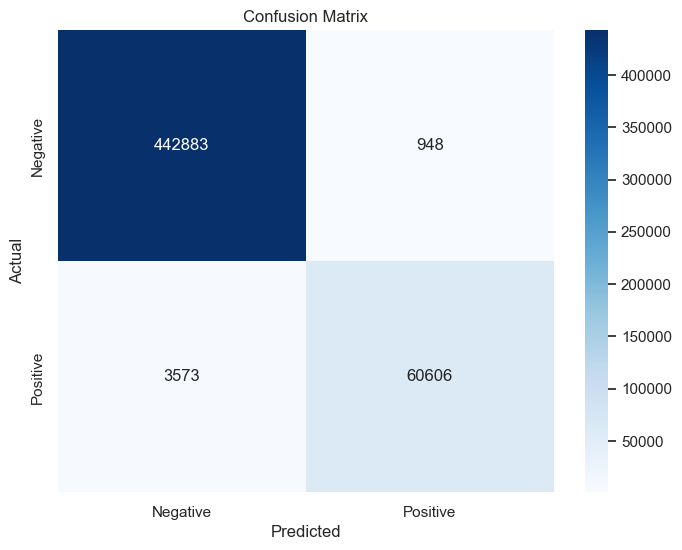

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 5


Testing: 100%|██████████| 3969/3969 [00:12<00:00, 330.62batch/s]


Test Loss: 0.0224, Test Accuracy: 0.9915, Test F1: 0.9913


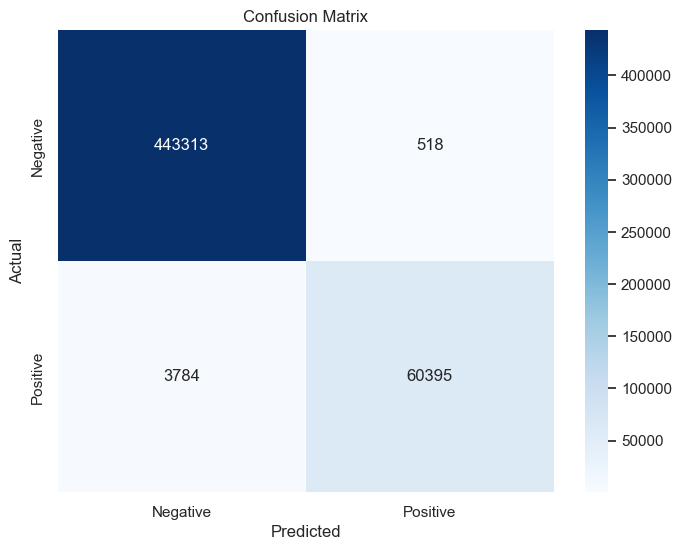

In [31]:
for i in range(1, epochs+1):
    path = f"./Models/saved_models/01/near_miss/PB_epoch_{i}.pth"
    model4.load_model(path)
    print(f"Epoch: {i}")
    model4.test(test_loader)
    y_pred = np.array(model4.test_predicted)
    y_true = []
    for _, labels in test_loader:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    plot_confusion_matrix(y_true, y_pred)
    model4.test_predicted = []

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/01/one_sided_1/'
model6 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/5: 100%|██████████| 15876/15876 [05:56<00:00, 44.59batch/s]


Epoch [1/5], Train Loss: 0.0230, Train Acc: 0.9863, Train F1: 0.9861


Epoch 2/5: 100%|██████████| 15876/15876 [05:47<00:00, 45.64batch/s]


Epoch [2/5], Train Loss: 0.0235, Train Acc: 0.9858, Train F1: 0.9857


Epoch 3/5: 100%|██████████| 15876/15876 [05:35<00:00, 47.26batch/s]


Epoch [3/5], Train Loss: 0.0249, Train Acc: 0.9850, Train F1: 0.9849


Epoch 4/5: 100%|██████████| 15876/15876 [05:34<00:00, 47.52batch/s]


Epoch [4/5], Train Loss: 0.0223, Train Acc: 0.9854, Train F1: 0.9852


Epoch 5/5: 100%|██████████| 15876/15876 [06:25<00:00, 41.18batch/s]


Epoch [5/5], Train Loss: 0.0238, Train Acc: 0.9853, Train F1: 0.9852


Testing: 100%|██████████| 3969/3969 [00:13<00:00, 299.78batch/s]


Test Loss: 0.0215, Test Accuracy: 0.9897, Test F1: 0.9894


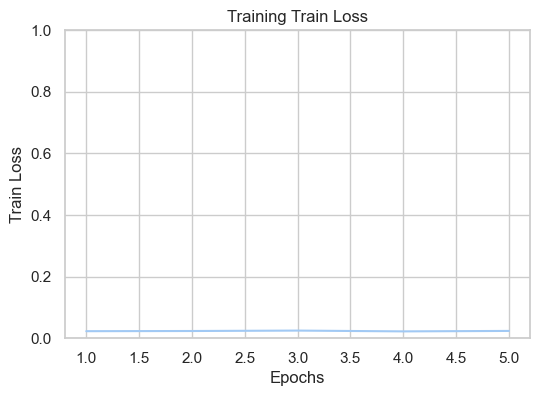

Testing: 100%|██████████| 3969/3969 [00:12<00:00, 329.62batch/s]


Test Loss: 0.0215, Test Accuracy: 0.9897, Test F1: 0.9894
One Sided Selection Test


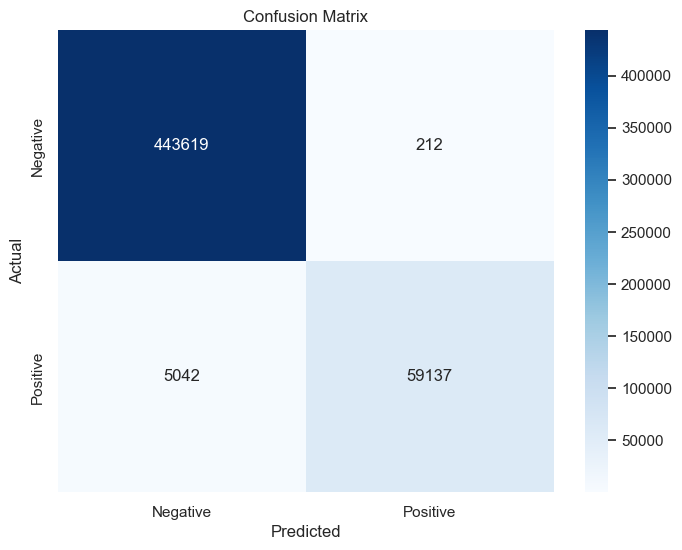

In [ ]:
# 29.45 min
sampler = 'one_sided'
params = {'n_neighbors': None}
learning_rate = 0.1
epochs = 5
save_factor = 1
model6.run(train_loader, learning_rate, epochs, save_factor, sampler, params)
model6.test(test_loader)
plot_metrics(model6.train_loss, len(model6.train_loss), title="Train Loss")
model6.test(test_loader)
print('One Sided Selection Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model6.test_predicted)

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 1


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 332.14batch/s]


Test Loss: 0.0173, Test Accuracy: 0.9915, Test F1: 0.9913


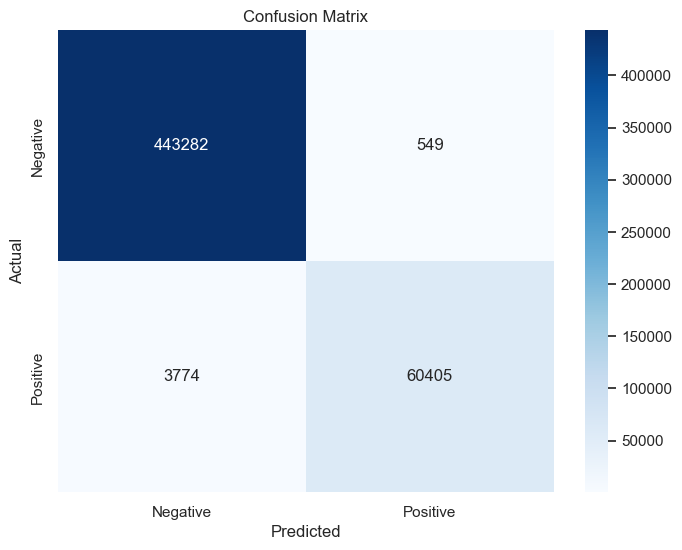

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 2


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 334.46batch/s]


Test Loss: 0.0171, Test Accuracy: 0.9909, Test F1: 0.9907


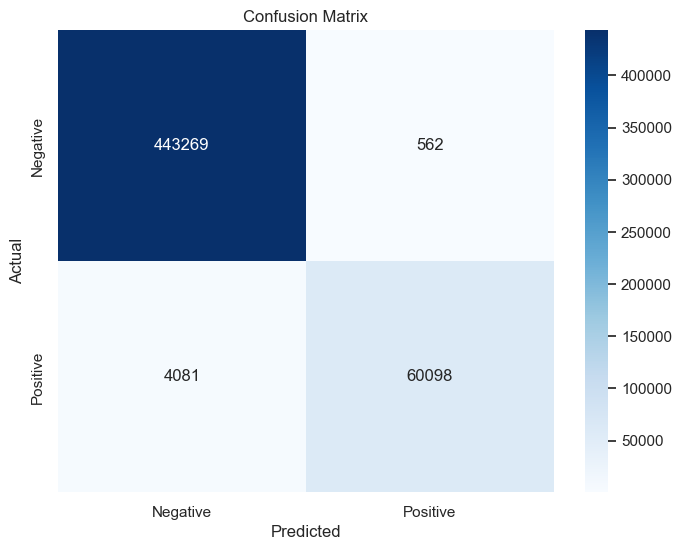

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 3


Testing: 100%|██████████| 3969/3969 [00:13<00:00, 300.07batch/s]


Test Loss: 0.0219, Test Accuracy: 0.9875, Test F1: 0.9879


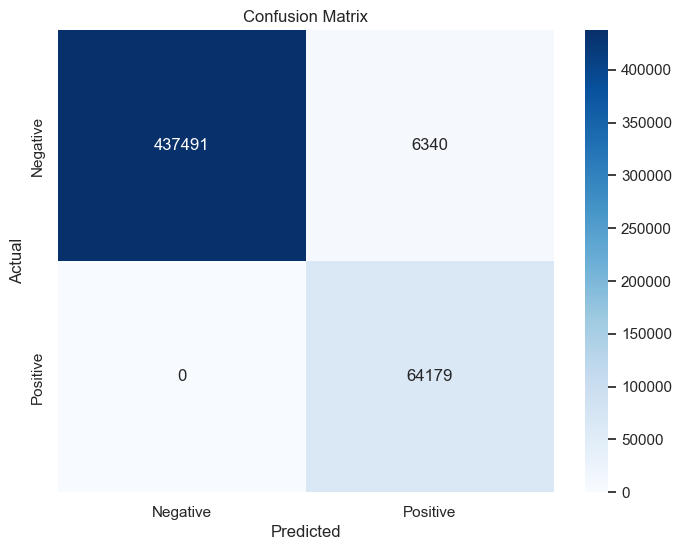

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 4


Testing: 100%|██████████| 3969/3969 [00:12<00:00, 325.66batch/s]


Test Loss: 0.0173, Test Accuracy: 0.9908, Test F1: 0.9906


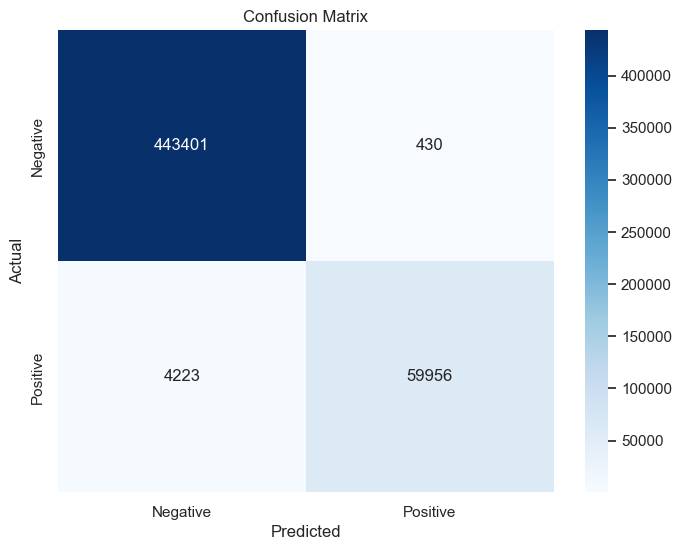

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 5


Testing: 100%|██████████| 3969/3969 [00:12<00:00, 326.52batch/s]


Test Loss: 0.0215, Test Accuracy: 0.9897, Test F1: 0.9894


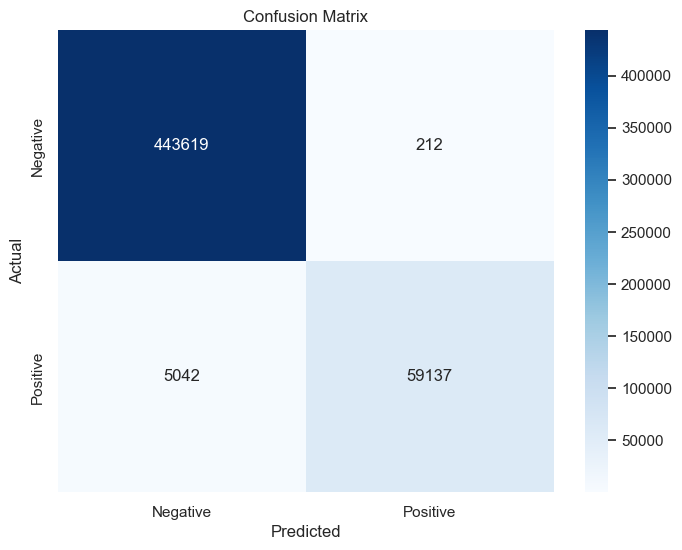

In [36]:
for i in range(1, epochs+1):
    path = f"./Models/saved_models/01/one_sided_1/PB_epoch_{i}.pth"
    model6.load_model(path)
    print(f"Epoch: {i}")
    model6.test(test_loader)
    y_pred = np.array(model6.test_predicted)
    y_true = []
    for _, labels in test_loader:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    plot_confusion_matrix(y_true, y_pred)
    model6.test_predicted = []

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/01/one_sided_2/'
model7 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/5: 100%|██████████| 15876/15876 [07:41<00:00, 34.39batch/s]


Epoch [1/5], Train Loss: 0.0243, Train Acc: 0.9857, Train F1: 0.9855


Epoch 2/5: 100%|██████████| 15876/15876 [06:05<00:00, 43.38batch/s]


Epoch [2/5], Train Loss: 0.0225, Train Acc: 0.9858, Train F1: 0.9856


Epoch 3/5: 100%|██████████| 15876/15876 [05:45<00:00, 46.00batch/s]


Epoch [3/5], Train Loss: 0.0218, Train Acc: 0.9862, Train F1: 0.9860


Epoch 4/5: 100%|██████████| 15876/15876 [08:23<00:00, 31.51batch/s]


Epoch [4/5], Train Loss: 0.0221, Train Acc: 0.9856, Train F1: 0.9854


Epoch 5/5: 100%|██████████| 15876/15876 [08:51<00:00, 29.86batch/s]


Epoch [5/5], Train Loss: 0.0222, Train Acc: 0.9856, Train F1: 0.9855


Testing: 100%|██████████| 3969/3969 [00:13<00:00, 304.40batch/s]


Test Loss: 0.0182, Test Accuracy: 0.9920, Test F1: 0.9918


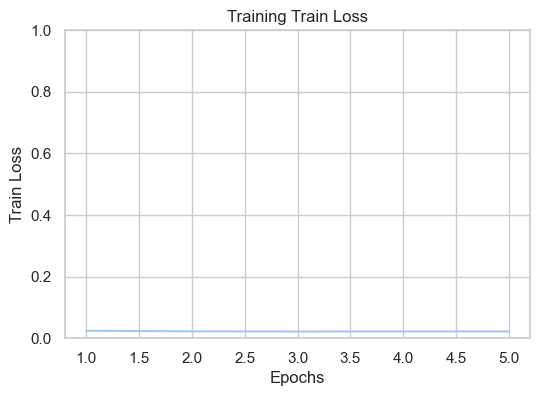

Testing: 100%|██████████| 3969/3969 [00:12<00:00, 326.85batch/s]


Test Loss: 0.0182, Test Accuracy: 0.9920, Test F1: 0.9918
One Sided Selection Test


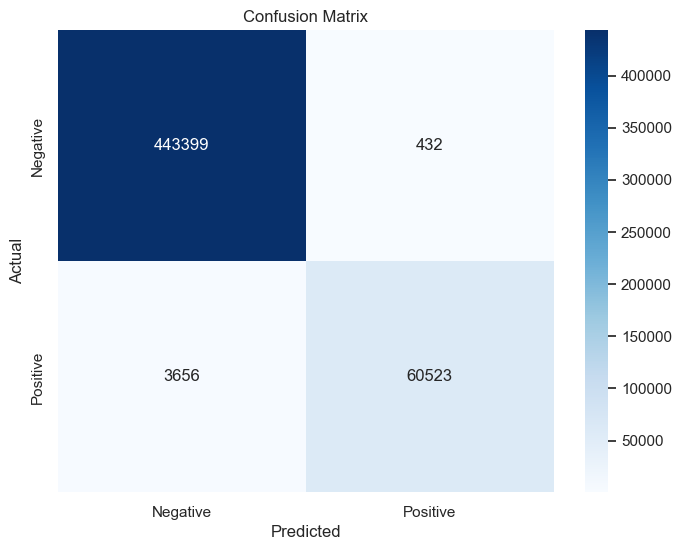

In [ ]:
# 37.14 min
sampler = 'one_sided'
params = {'n_neighbors': 2}
learning_rate = 0.1
epochs = 5
save_factor = 1
model7.run(train_loader, learning_rate, epochs, save_factor, sampler, params)
model7.test(test_loader)
plot_metrics(model7.train_loss, len(model7.train_loss), title="Train Loss")
model7.test(test_loader)
print('One Sided Selection Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model7.test_predicted)

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 1


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 332.12batch/s]


Test Loss: 0.0167, Test Accuracy: 0.9914, Test F1: 0.9912


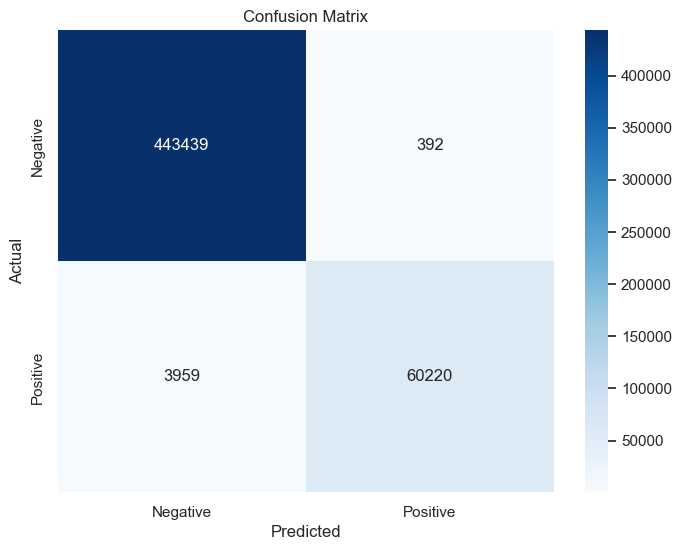

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 2


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 339.41batch/s]


Test Loss: 0.0175, Test Accuracy: 0.9920, Test F1: 0.9918


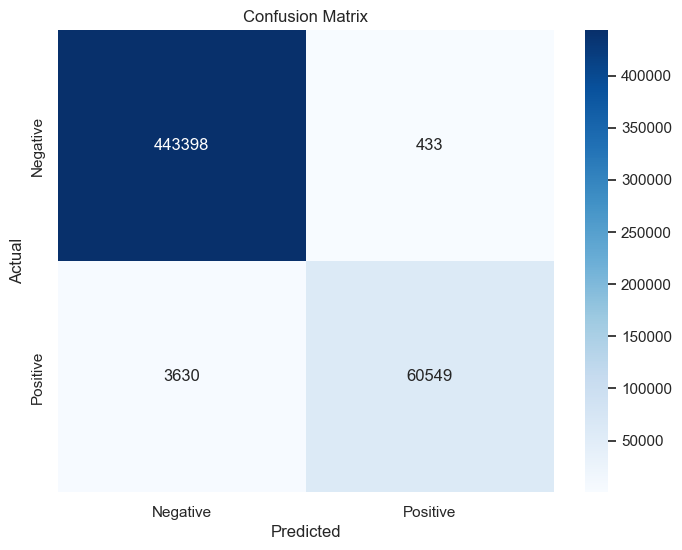

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 3


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 339.50batch/s]


Test Loss: 0.0193, Test Accuracy: 0.9879, Test F1: 0.9882


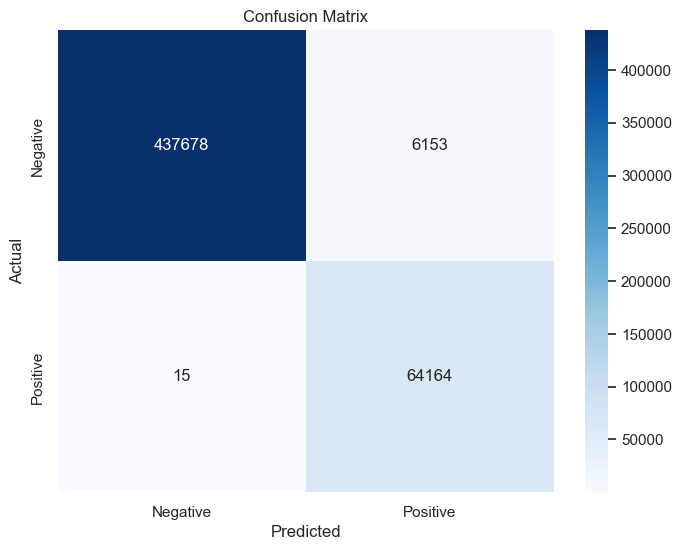

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 4


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 340.31batch/s]


Test Loss: 0.0219, Test Accuracy: 0.9877, Test F1: 0.9881


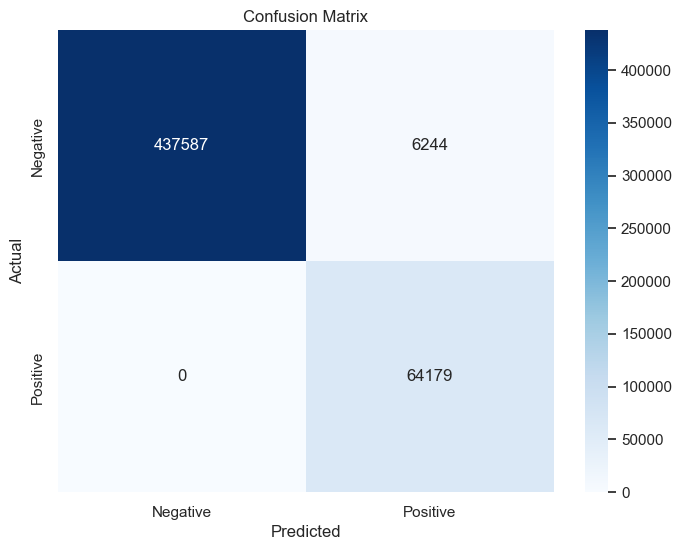

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 5


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 331.45batch/s]


Test Loss: 0.0182, Test Accuracy: 0.9920, Test F1: 0.9918


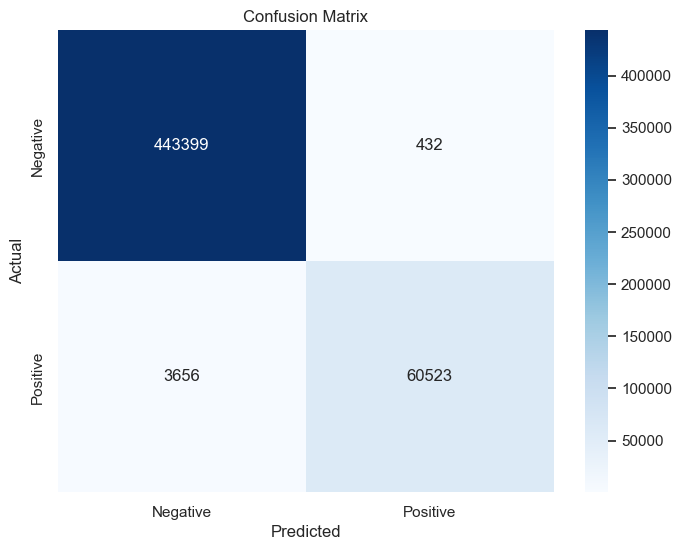

In [39]:
for i in range(1, epochs+1):
    path = f"./Models/saved_models/01/one_sided_2/PB_epoch_{i}.pth"
    model7.load_model(path)
    print(f"Epoch: {i}")
    model7.test(test_loader)
    y_pred = np.array(model7.test_predicted)
    y_true = []
    for _, labels in test_loader:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    plot_confusion_matrix(y_true, y_pred)
    model7.test_predicted = []

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/02/standard/'
model8 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/5: 100%|██████████| 15876/15876 [01:28<00:00, 178.39batch/s]


Epoch [1/5], Train Loss: 0.0179, Train Acc: 0.9905, Train F1: 0.9903


Epoch 2/5: 100%|██████████| 15876/15876 [01:25<00:00, 185.16batch/s]


Epoch [2/5], Train Loss: 0.0172, Train Acc: 0.9908, Train F1: 0.9905


Epoch 3/5: 100%|██████████| 15876/15876 [01:23<00:00, 189.16batch/s]


Epoch [3/5], Train Loss: 0.0180, Train Acc: 0.9899, Train F1: 0.9896


Epoch 4/5: 100%|██████████| 15876/15876 [01:25<00:00, 186.57batch/s]


Epoch [4/5], Train Loss: 0.0175, Train Acc: 0.9901, Train F1: 0.9898


Epoch 5/5: 100%|██████████| 15876/15876 [01:25<00:00, 185.01batch/s]


Epoch [5/5], Train Loss: 0.0190, Train Acc: 0.9884, Train F1: 0.9881


Testing: 100%|██████████| 3969/3969 [00:11<00:00, 350.96batch/s]

Test Loss: 0.0175, Test Accuracy: 0.9903, Test F1: 0.9900


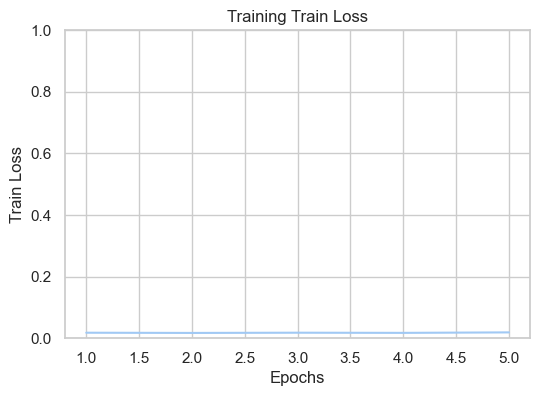

Testing: 100%|██████████| 3969/3969 [00:10<00:00, 382.23batch/s]


Test Loss: 0.0175, Test Accuracy: 0.9903, Test F1: 0.9900
Standard Test


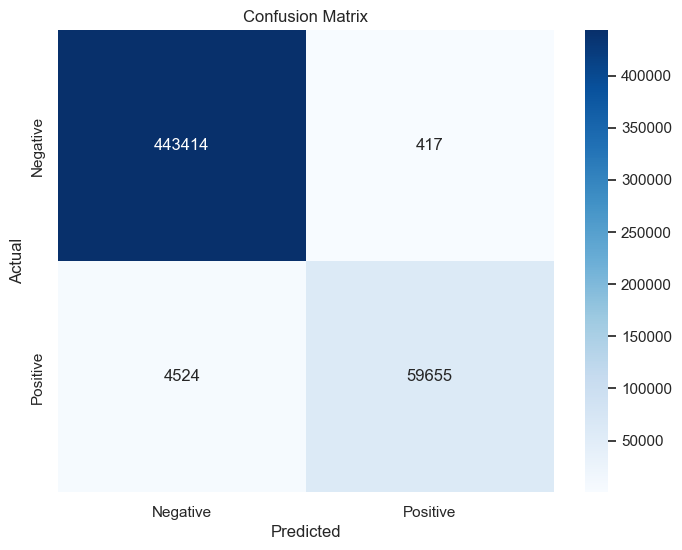

In [ ]:
# 8.31 min
sampler = None
params = None
learning_rate = 0.1
epochs = 5
save_factor = 1
model8.run(train_loader, learning_rate, epochs, save_factor, sampler, params)
model8.test(test_loader)
plot_metrics(model8.train_loss, len(model8.train_loss), title="Train Loss")
model8.test(test_loader)
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model8.test_predicted)

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 1


Testing: 100%|██████████| 3969/3969 [00:10<00:00, 384.73batch/s]


Test Loss: 0.0175, Test Accuracy: 0.9898, Test F1: 0.9895


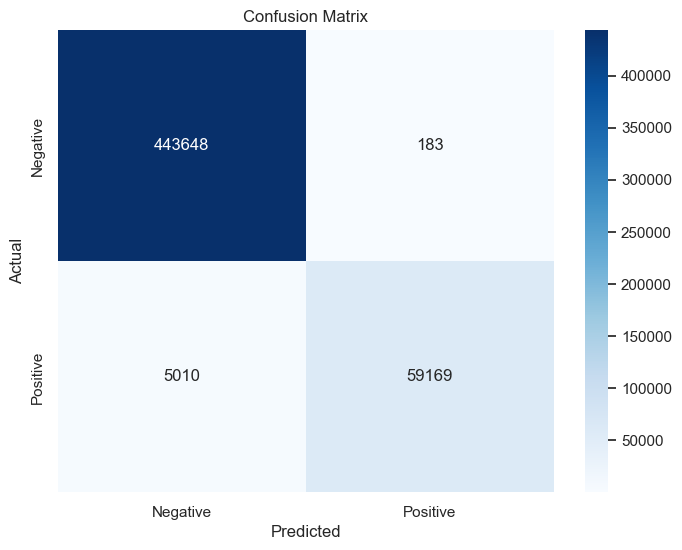

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 2


Testing: 100%|██████████| 3969/3969 [00:10<00:00, 387.55batch/s]


Test Loss: 0.0183, Test Accuracy: 0.9890, Test F1: 0.9887


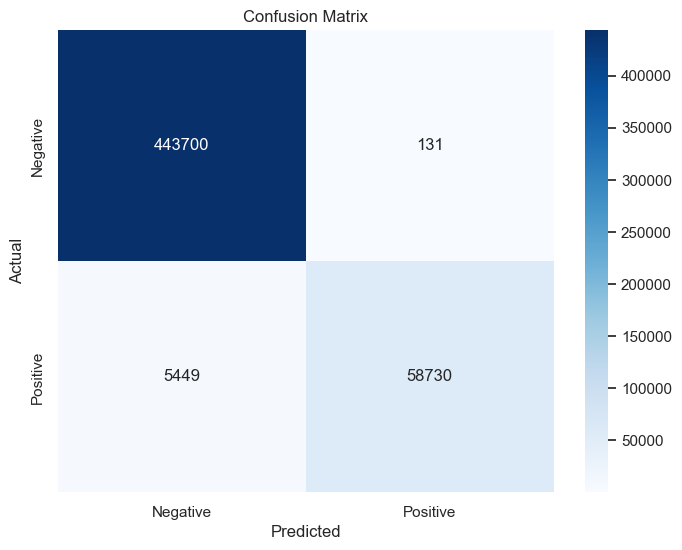

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 3


Testing: 100%|██████████| 3969/3969 [00:10<00:00, 385.55batch/s]


Test Loss: 0.0158, Test Accuracy: 0.9919, Test F1: 0.9917


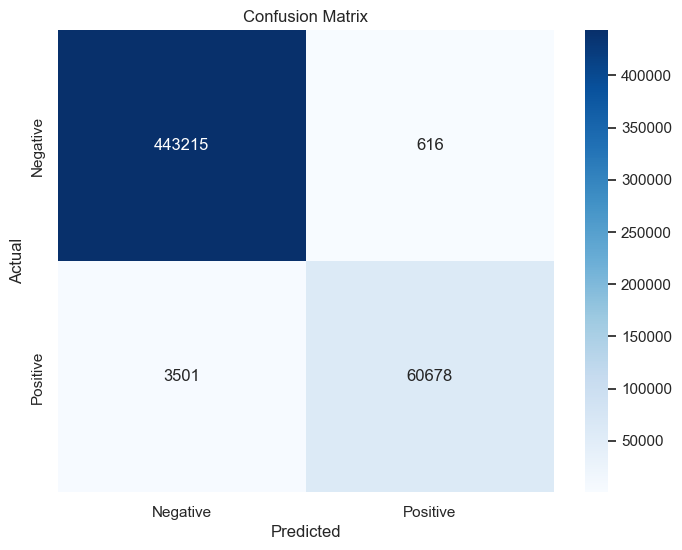

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 4


Testing: 100%|██████████| 3969/3969 [00:10<00:00, 382.60batch/s]


Test Loss: 0.0166, Test Accuracy: 0.9906, Test F1: 0.9904


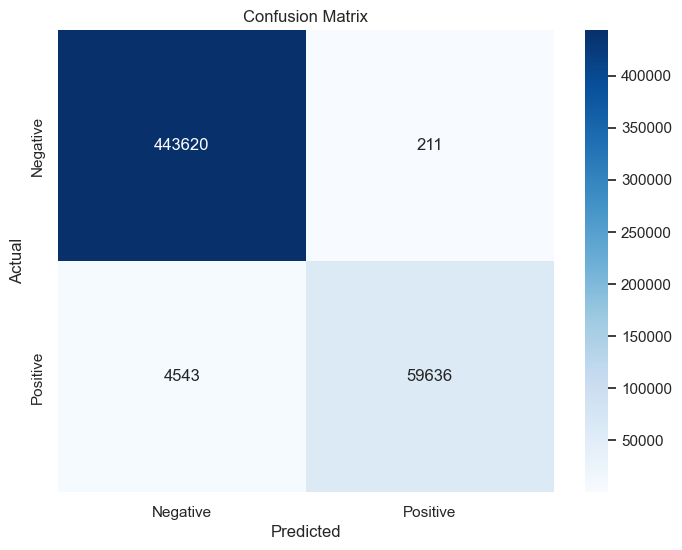

c:\Users\adi_s\Desktop\LSTM\Models\models.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Epoch: 5


Testing: 100%|██████████| 3969/3969 [00:10<00:00, 371.12batch/s]


Test Loss: 0.0175, Test Accuracy: 0.9903, Test F1: 0.9900


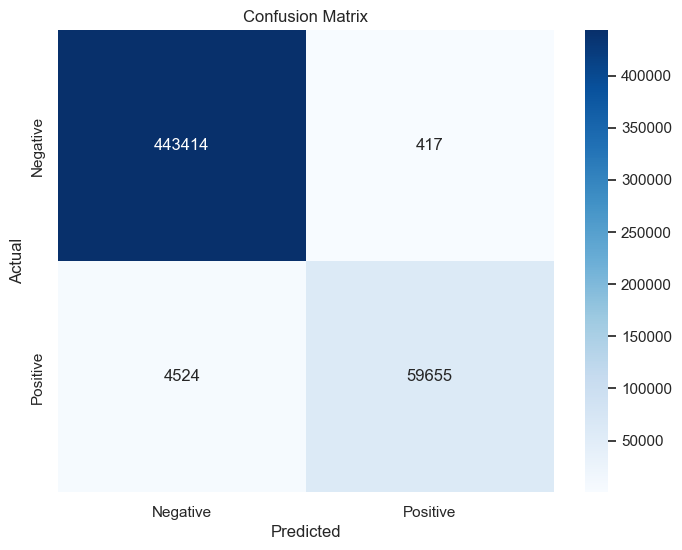

In [43]:
for i in range(1, epochs+1):
    path = f"./Models/saved_models/01/standard/PB_epoch_{i}.pth"
    model8.load_model(path)
    print(f"Epoch: {i}")
    model8.test(test_loader)
    y_pred = np.array(model8.test_predicted)
    y_true = []
    for _, labels in test_loader:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    plot_confusion_matrix(y_true, y_pred)
    model8.test_predicted = []